# Neural Networks - Deep Learning

## Third Assignment - Multiclass Classification + Autoencoder
### Dimitrios Tikvinas AEM: 9998

# Part 1 : Multiclass Classification using Radial Basis Function Neural Network on the CIFAR-10

## Introduction

In this assignment we are going to implement **Radial Basis Function Neural Network** model in order to efficiently perform multiclass classification in the well-known and significant in the field of computer vision dataset **CIFAR-10**. It is consisted of 60000 **32x32 colour**(*RGB, meaning 3 color channel*) images  in **10** classes, with **6000 images per class**(*equalized*).

Throughout our project, we will make predictions on the test set ONLY for educational purposes, since we want to leave the test set untouched and unknown up until the final evaluation of the ultimate model we produce.

### Imports

In [1]:
import tensorflow as tf
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.manifold import TSNE, MDS

from scipy.spatial.distance import pdist

import numpy as np
import seaborn as sns
import random 
import time

import matplotlib.pyplot as plt

### Loading the CIFAR-10 Dataset

In [2]:
# Load CIFAR-10 dataset
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()
# Define class labels as strings for CIFAR-10
class_labels = [
    'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
]


num_classes = 10 # total classes

print("X_train shape", X_train.shape) 
print("Y_train shape", Y_train.shape)
print("X_test shape", X_test.shape)
print("Y_test shape", Y_test.shape)

X_train shape (50000, 32, 32, 3)
Y_train shape (50000, 1)
X_test shape (10000, 32, 32, 3)
Y_test shape (10000, 1)


### Examples of CIFAR-10 input images

We are going to show some input images to see what we are about to deal with

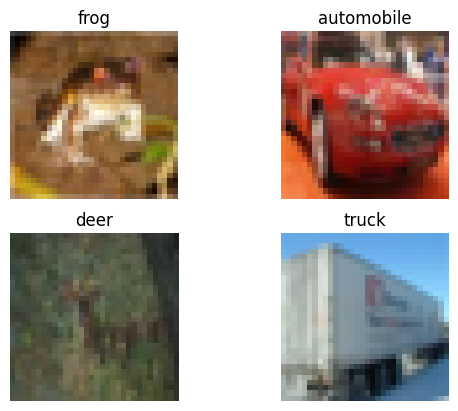

In [3]:
# Display some CIFAR-10 images
plt.subplot(221)
plt.imshow(X_train[0])
plt.axis('off')
plt.title(class_labels[Y_train[0][0]])
plt.subplot(222)
plt.imshow(X_train[5])
plt.axis('off')
plt.title(class_labels[Y_train[5][0]])
plt.subplot(223)
plt.imshow(X_train[10])
plt.axis('off')
plt.title(class_labels[Y_train[10][0]])
plt.subplot(224)
plt.imshow(X_train[15])
plt.axis('off')
plt.title(class_labels[Y_train[15][0]])
plt.show()

## Dataset Preprocessing 

Prior to implementing any Radial Basis Function (RBF) Neural Network, meticulous dataset preprocessing stands as a crucial prerequisite. This pivotal step is instrumental in enhancing accessibility, streamlining handling and management, and ultimately optimizing the performance of the machine learning model. By carefully preparing the dataset, we lay the foundation for a more seamless integration with the RBF Neural Network, facilitating enhanced efficiency and superior outcomes.

In [4]:
from sklearn.preprocessing import OneHotEncoder

# Convert to float32 for easier management
X_train, X_test = np.array(X_train, dtype=np.float32), np.array(X_test, dtype=np.float32)

# Flatten the images to be 1-D vectors
X_train, X_test = X_train.reshape(X_train.shape[0], -1), X_test.reshape(X_test.shape[0], -1)

# Normalize to [0, 1]
X_train, X_test= (X_train / 255.0 ), (X_test / 255.0 )

# Keep true outputs unattached before applying One-Hot Encoding
Y_train_raw = Y_train
Y_test_raw = Y_test

# One-hot encode the labels
encoder = OneHotEncoder(sparse_output=False)
Y_train= encoder.fit_transform(Y_train.reshape(-1, 1))
Y_test = encoder.transform(Y_test.reshape(-1, 1))


### PCA dimensionality reduction

In our endeavor to handle a vast dataset comprising 50,000 images, each boasting 3,072 pixels, we are confronted with a formidable processing challenge. Undoubtedly, within this extensive dataset, certain pixels can be deemed redundant without compromising the impending model's performance. To address this issue, we will leverage the power of Principal Component Analysis (PCA), a sophisticated linear dimensionality reduction technique. The primary objective of PCA is to preserve the inherent linear structure between data points within a new, more manageable low-dimensional space. Our targeted outcome is to retain a substantial 90% of the critical information while alleviating the computational burden associated with the original dataset.

In [5]:
start = time.time()

pca = PCA(n_components=0.9).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

end = time.time()
print("PCA elapsed time: {}s\n".format(end-start))
print("We extract {} feautures from the original {}.".format(X_train_pca.shape[1],X_train.shape[1]))
print('Cumulative explained variation for {} principal components: {}'.format(X_train_pca.shape[1], np.sum(pca.explained_variance_ratio_)))


PCA elapsed time: 26.00365400314331s

We extract 99 feautures from the original 3072.
Cumulative explained variation for 99 principal components: 0.9003188014030457


Our goal was that the new components (features) achieve 90% explained variance of the initial ones. We see that by creating only 99 of them we can achieve this number (roughly 1/34th of the initial 3072 features).

## Data Visualization

In the process of visualizing data within a low-dimensionality space, our aim is to uncover the extent of separability among various classes. The greater the degree of separability, the more adept we become at forming distinct clusters, thereby amplifying the efficacy of the RBF Neural Network.

### 2-D Visualization using tSNE

**tSNE** is a non-linear dimensionality reduction technique that is commonly used when trying to visualize high-dimensional data. What tSNE does is that it tries to make more similar data neighbors and put dissimilar data further away.
We apply the tSNE algorithm upon the PCA dataset, in order to suppress some noise and speed up the computation of pairwise distances between samples.

t-SNE time elapsed: 100.53976607322693s


<AxesSubplot: xlabel='t-SNE Component 1', ylabel='t-SNE Component 2'>

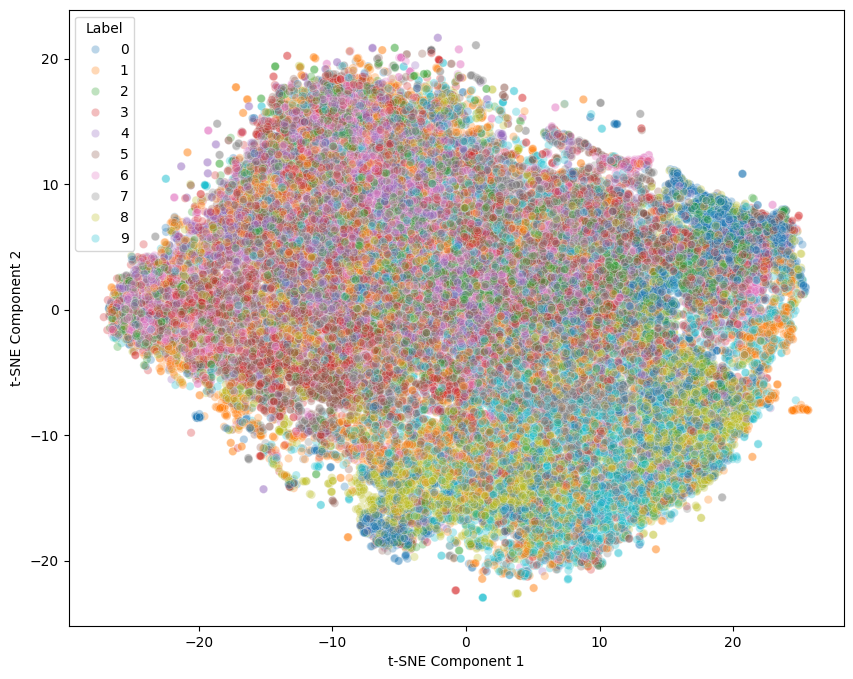

In [6]:
# Apply tSNE
start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=500, n_iter_without_progress=50,
            early_exaggeration=40, learning_rate=500)
x_train_tSNE = tsne.fit_transform(X_train_pca)

# Convert NumPy array to DataFrame
df_tSNE = pd.DataFrame(data=x_train_tSNE, columns=['t-SNE Component 1', 't-SNE Component 2'])

# Add labels to the DataFrame
df_tSNE['Label'] = Y_train_raw

end = time.time()
print('t-SNE time elapsed: {}s'.format(end-start))

# Plot data
plt.figure(figsize=(10,8))
sns.scatterplot(
    x='t-SNE Component 1', y='t-SNE Component 2',
    hue='Label',
    palette=sns.color_palette(),
    data=df_tSNE,
    legend="full",
    alpha=0.3
)

From the aforementioned analysis, it becomes apparent that the samples lack a satisfactory level of separability, foreshadowing a potential deficiency of performance in the upcoming implementation of the RBF Neural Network.

## Define the base RBF model

We use a hybrid technique for training the RBF model: \\

1. The centers of the Gaussian kernels in the hidden layer are found by applying the KMeans algorithm (number of centers defined by us). 
2. The weights are found analytically. 

As for the variance used in the gaussian kernels, this was calculated based on an heuristic found in the Haykin book.

In [7]:
def RBF(num_neurons, X_train, Y_train, Y_train_raw, X_test, Y_test_raw, metrics=False, method=None, print_=False):
    
    if method == "kmeans": 
        # Apply K-Means to find the centers of the kernels in the hidden layer
        start = time.time()

        kmeans = KMeans(n_clusters=num_neurons, init='k-means++', n_init=10, verbose=0).fit(X_train)
        centers = kmeans.cluster_centers_

        end = time.time()
        if print_ == True:
            print("KMeans elapsed time: {}s".format(end - start))

    elif method == "random":
        # Randomly select centers
        start = time.time()

        centers_indices = np.random.choice(len(X_train), num_neurons, replace=False)
        centers = X_train[centers_indices, :]
        
        end = time.time()
        if print_ == True:
            print("Randomly selection of centers elapsed time: {}s".format(end - start))
            
            
    # Variance of each kernel
    dists = pdist(centers, metric='euclidean')
    d_max = np.amax(dists)
    var = d_max / tf.math.sqrt(2 * float(centers.shape[0]))

    # Pass training data through the kernels
    start = time.time()
    x_train_kernel = rbf_kernel(X_train, Y=centers, gamma=np.float32(1 / (2 * var)))
    end = time.time()
    if print_ == True:
        print("Transforming training data: {}s".format(end - start))
    
    # Calculate weights
    start = time.time()
    w = np.dot(np.linalg.pinv(x_train_kernel), Y_train)
    end = time.time()
    if print_ == True:
        print("Calculating weights: {}s".format(end - start))

    # Evaluate test set
    start = time.time()
    x_test_kernel = rbf_kernel(X_test, Y=centers, gamma=np.float32(1 / (2 * var)))
    y_pred_test = np.dot(x_test_kernel, w)
    y_pred_test = np.argmax(y_pred_test, 1)
    end = time.time()
    
    
    if print_ == True:
        print("Testing elapsed time: {}s\n".format(end - start))

    # Evaluate training set
    y_pred_train = np.dot(x_train_kernel, w)
    y_pred_train = np.argmax(y_pred_train, 1)

    train_accuracy = accuracy_score(Y_train_raw, y_pred_train)
    test_accuracy = accuracy_score(Y_test_raw, y_pred_test)

    
    if metrics is True:
        labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
        
        # Create and display confusion matrix
        M = confusion_matrix(Y_test_raw, y_pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)

        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # Accuracy, precision, recall, and f1-score
        print(classification_report(Y_test_raw, y_pred_test))

    return train_accuracy, test_accuracy

### Test RBF model for different number of centers and methods 

In [15]:
# 10 centers
train_accuracy_kmeans, test_accuracy_kmeans = RBF(10,X_train_pca,Y_train,Y_train_raw,X_test_pca,Y_test_raw,None,"kmeans", True)

train_accuracy_random, test_accuracy_random = RBF(10,X_train_pca,Y_train,Y_train_raw,X_test_pca,Y_test_raw,None,"random", True)

print("K-means - Training Accuracy: {:.2%}, Testing Accuracy: {:.2%}".format(train_accuracy_kmeans, test_accuracy_kmeans))
print("Random Selection - Training Accuracy: {:.2%}, Testing Accuracy: {:.2%}".format(train_accuracy_random, test_accuracy_random))

# 100 centers
train_accuracy_kmeans, test_accuracy_kmeans = RBF(100,X_train_pca,Y_train,Y_train_raw,X_test_pca,Y_test_raw,None,"kmeans", True)

train_accuracy_random, test_accuracy_random = RBF(100,X_train_pca,Y_train,Y_train_raw,X_test_pca,Y_test_raw,None,"random", True)

print("K-means - Training Accuracy: {:.2%}, Testing Accuracy: {:.2%}".format(train_accuracy_kmeans, test_accuracy_kmeans))
print("Random Selection - Training Accuracy: {:.2%}, Testing Accuracy: {:.2%}".format(train_accuracy_random, test_accuracy_random))

KMeans elapsed time: 17.32607674598694s
Transforming training data: 0.10254025459289551s
Calculating weights: 0.09615373611450195s
Testing elapsed time: 0.015682458877563477s

Randomly selection of centers elapsed time: 0.0s
Transforming training data: 0.05038905143737793s
Calculating weights: 0.11498498916625977s
Testing elapsed time: 0.030137300491333008s

K-means - Training Accuracy: 24.01%, Testing Accuracy: 24.57%
Random Selection - Training Accuracy: 20.94%, Testing Accuracy: 21.47%
KMeans elapsed time: 16.760413885116577s
Transforming training data: 0.0994882583618164s
Calculating weights: 0.10028576850891113s
Testing elapsed time: 0.017284870147705078s

Randomly selection of centers elapsed time: 0.0s
Transforming training data: 0.0499730110168457s
Calculating weights: 0.11729764938354492s
Testing elapsed time: 0.016233205795288086s

K-means - Training Accuracy: 24.62%, Testing Accuracy: 25.06%
Random Selection - Training Accuracy: 20.15%, Testing Accuracy: 20.18%


## Fine Tuning of the RBF NN model using GridSearch

Fine-tuning is invaluable for optimizing performance. It systematically explores hyperparameter combinations, enhancing model accuracy and robustness. Each of the candidate models will be cross-validated using stratified 3-fold cross validation in order to achieve more robust estimations of the accuracy of each model. 
This process ensures that the ultimate model is finely calibrated to yield the best results on the given dataset.

In [9]:
def custom_grid_search(X, Y, Y_raw, neurons, methods):
    best_accuracy = 0
    best_params = {}

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    for num_neurons in neurons:
        for method in methods:
            print("\nTesting hyperparameters - num_neurons: {}, method: {}".format(num_neurons, method))
            
            fold_accuracies = []

            # Perform cross-validation
            for train_index, test_index in skf.split(X, Y_raw):
                X_train_fold, X_test_fold = X[train_index], X[test_index]
                y_train_fold, y_test_fold = Y[train_index], Y[test_index]
                y_raw_train_fold, y_raw_test_fold = Y_raw[train_index], Y_raw[test_index]

                # Call your RBF function with the current set of hyperparameters
                train_fold_accuracy, val_fold_accuracy = RBF(num_neurons,
                    X_train_fold, y_train_fold, y_raw_train_fold,
                    X_test_fold, y_raw_test_fold, False, method, False)

                # append val_accuracy in the total number of accuracies
                fold_accuracies.append(val_fold_accuracy)

            # Calculate mean accuracy across folds
            mean_accuracy = np.mean(fold_accuracies)

            # Print mean accuracy for the current hyperparameter combination
            print("Mean Cross-Validation Accuracy: {:.4f}".format(mean_accuracy))

            # Update the best parameters if the current combination is better
            if mean_accuracy > best_accuracy:
                best_accuracy = mean_accuracy
                best_params = {'num_neurons': num_neurons, 'method': method}

    print("\n\nBest Parameters:", best_params)
    print("Best Cross-Validation Accuracy: {:.4f}".format(best_accuracy))
    return best_params

We are set to execute the custom GridSearch outlined above, exploring various neuron counts for both center-picking methods. This meticulous exploration aims to identify the optimal configuration, ensuring the RBF Neural Network performs at its peak efficiency.

In [11]:
best_parameters = custom_grid_search(X_train_pca, Y_train, Y_train_raw, [100, 200, 500, 1000, 1500], ['kmeans', 'random'])


Testing hyperparameters - num_neurons: 100, method: kmeans
Mean Cross-Validation Accuracy: 0.2420

Testing hyperparameters - num_neurons: 100, method: random
Mean Cross-Validation Accuracy: 0.1886

Testing hyperparameters - num_neurons: 200, method: kmeans
Mean Cross-Validation Accuracy: 0.2438

Testing hyperparameters - num_neurons: 200, method: random
Mean Cross-Validation Accuracy: 0.2081

Testing hyperparameters - num_neurons: 500, method: kmeans
Mean Cross-Validation Accuracy: 0.2547

Testing hyperparameters - num_neurons: 500, method: random
Mean Cross-Validation Accuracy: 0.2238

Testing hyperparameters - num_neurons: 1000, method: kmeans
Mean Cross-Validation Accuracy: 0.2730

Testing hyperparameters - num_neurons: 1000, method: random
Mean Cross-Validation Accuracy: 0.2483


Best Parameters: {'num_neurons': 1000, 'method': 'kmeans'}
Best Cross-Validation Accuracy: 0.2730


We will now train the RBF model using the best-fitted parameters extracted from the custom grid search and also produce a Confusion Matrix

KMeans elapsed time: 115.85625147819519s
Transforming training data: 0.6351885795593262s
Calculating weights: 8.864821195602417s
Testing elapsed time: 0.13459277153015137s



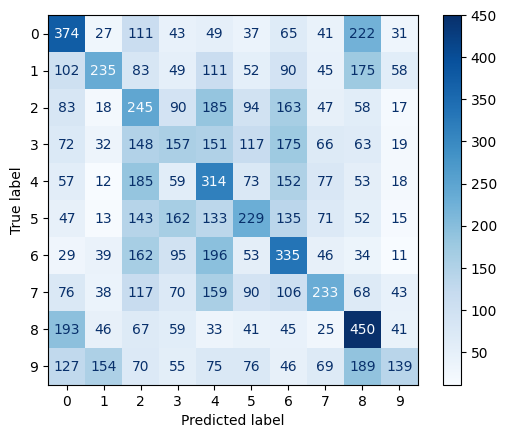

              precision    recall  f1-score   support

           0       0.32      0.37      0.35      1000
           1       0.38      0.23      0.29      1000
           2       0.18      0.24      0.21      1000
           3       0.19      0.16      0.17      1000
           4       0.22      0.31      0.26      1000
           5       0.27      0.23      0.25      1000
           6       0.26      0.34      0.29      1000
           7       0.32      0.23      0.27      1000
           8       0.33      0.45      0.38      1000
           9       0.35      0.14      0.20      1000

    accuracy                           0.27     10000
   macro avg       0.28      0.27      0.27     10000
weighted avg       0.28      0.27      0.27     10000

Best Model with methodkmeans- Training Accuracy: 28.55%, Testing Accuracy: 27.11%


In [23]:
train_accuracy, test_accuracy = RBF(best_parameters.get("num_neurons"),X_train_pca,Y_train,Y_train_raw,X_test_pca,Y_test_raw,True ,best_parameters.get("method"), True)


print("Best Model with method "+best_parameters.get("method") +"- Training Accuracy: {:.2%}, Testing Accuracy: {:.2%}".format(train_accuracy, test_accuracy))

The performance turned out to be less than ideal, as somewhat anticipated from the tSNE graph. The dataset's images are intricate and diverse, making it challenging for a basic RBF model to capture the underlying patterns effectively.

## RBF with KMeans-RLS hybrid training
As we saw in the previous implementation of the RBFNN, it is hard to calculate the weights of the RBF model analytically when having a lot of samples in the training set, leading most of the times into memory-exhaustive situtations. A way to tackle this problem is by using **Recursive Least squares (RLS)**. This way no matrix inversion is needed and as a result, we can train a model with an even bigger number of kernels.

In [12]:
def RBF_RLS(num_centers, X_train, Y_train, Y_train_raw, X_test, Y_test_raw, metrics=False):
    print("Number of centers: {}\n".format(num_centers))

    # Initial conditions for RLS
    l = 1e-3
    P = (1/l) * np.identity(num_centers)
    w = np.zeros((num_centers, num_classes))

    # K-Means
    start = time.time()
    kmeans = KMeans(n_clusters=num_centers, init='k-means++', n_init=10, verbose=0).fit(X_train)
    end = time.time()
    KMeans_time = end - start
    print("K-Means elapsed time: {}s\n".format(KMeans_time))

    # Centers of the kernels
    centers = kmeans.cluster_centers_

    # Variance of each kernel
    dists = pdist(centers, metric='euclidean')
    d_max = np.amax(dists)
    var = d_max / np.sqrt(2 * float(centers.shape[0]))

    # Main loop of RLS
    start = time.time()
    for i in range(X_train.shape[0]):
        phi = rbf_kernel(X_train[i].reshape(1, -1), Y=centers, gamma=np.float32(1 / (2 * var)))
        P -= np.linalg.multi_dot([P, phi.T, phi, P]) / (1 + np.linalg.multi_dot([phi, P, phi.T]))
        g = np.dot(P, phi.T)
        a = Y_train[i].reshape(-1, 1) - np.dot(w.T, phi.T)
        w += np.dot(g, a.T)

    end = time.time()
    RLS_time = end - start
    print("RLS elapsed time: {}s\n".format(RLS_time))

    # Evaluate on the test set
    x_test_kernel = rbf_kernel(X_test, Y=centers, gamma=np.float32(1 / (2 * var)))

    y_pred_test = np.dot(x_test_kernel, w)
    y_pred_test = np.argmax(y_pred_test, axis=1)

    print('Test set accuracy: ', accuracy_score(Y_test_raw, y_pred_test))
    print('\n')

    if metrics:
        labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

        # Create and display the confusion matrix
        M = confusion_matrix(Y_test_raw, y_pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=M, display_labels=labels)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()

        # Accuracy, precision, recall, and f1-score
        print(classification_report(Y_test_raw, y_pred_test))

    return KMeans_time, RLS_time

Let's see how long will it take for the **creation of centers** and for **calculating the weights** for different number of neurons in RBF's hidden layer

Number of centers: 100

K-Means elapsed time: 49.9853298664093s

RLS elapsed time: 25.66952896118164s

Test set accuracy:  0.2529


Number of centers: 200

K-Means elapsed time: 92.20395541191101s

RLS elapsed time: 76.25425124168396s

Test set accuracy:  0.2461


Number of centers: 500

K-Means elapsed time: 97.6643271446228s

RLS elapsed time: 158.71467900276184s

Test set accuracy:  0.2458


Number of centers: 1000

K-Means elapsed time: 107.83954524993896s

RLS elapsed time: 377.2709336280823s

Test set accuracy:  0.2527


Number of centers: 1500

K-Means elapsed time: 164.22321224212646s

RLS elapsed time: 730.6068472862244s

Test set accuracy:  0.2513




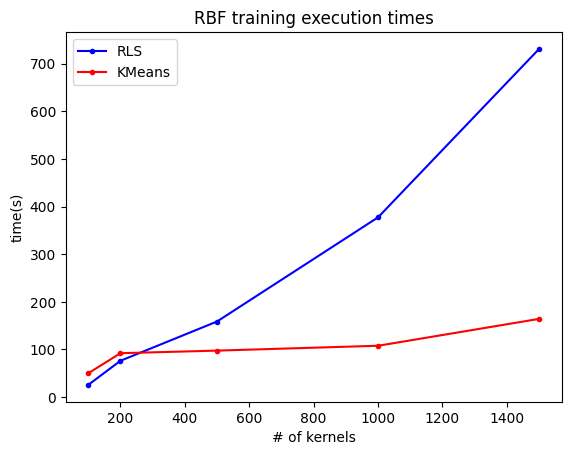

In [13]:
num_centers = np.array([100,200,500,1000,1500])
RLS_times = []
K_Means_times = []

for center in num_centers:
    K_Means_time, RLS_time = RBF_RLS(center,X_train_pca,Y_train,Y_train_raw,X_test_pca,Y_test_raw, metrics=False)
    K_Means_times.append(K_Means_time)
    RLS_times.append(RLS_time)
    
plt.plot(num_centers,RLS_times,'.-b',label='RLS')
plt.plot(num_centers,K_Means_times,'.-r',label='KMeans')
plt.xlabel('# of kernels')
plt.ylabel('time(s)')
plt.title('RBF training execution times')
plt.legend()
plt.show()

The first thing we notice is that increasing the number of kernels in the hidden layer doesn't necessarily causes the models to perform better. The perfomance actually remains pretty much the same. So, based on Occam's razor the best model to choose in this case would be the one with 100 Gaussian kernels. \ Moreover, regarding the training times, we can see that KMeans grows linearly with respect to the number of kernels while RLS grows in polynomial time. So, despite the fact that RLS allows us to train models with an even bigger number of kernels, this is not optimal, both time-wise and performance-wise.

# Part 2: Autoencoder on the MNIST

## Imports

In [13]:
# Imports
import numpy as np
import tensorflow
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.layers import Layer
from skimage import metrics

## Load the Dataset

In [14]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [15]:
# Normalize the data
x_train_un = x_train.astype('float32') / 255.
x_test_un = x_test.astype('float32') / 255.

In [16]:
# Flatten the images
x_train = x_train_un.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_Test = x_test_un.reshape((len(x_test), np.prod(x_test.shape[1:])))

We want to randomize the dataset in order to increase the generalization of the upcoming model

In [17]:
# Randomize both the training and test
permutation = np.random.permutation(len(x_train))
x_train, y_train = x_train[permutation], y_train[permutation]
permutation = np.random.permutation(len(x_test))
x_test, y_test = x_Test[permutation], y_test[permutation]

## Project 1: Autoencoder for Predicting the Next Digit
In this project, we aim to develop an autoencoder that generates an output image representing the next digit in sequence based on the input image.

In [18]:
# Create the encoder
encoder_input = Input(shape=(784,))
encoded = Dense(128, activation='relu')(encoder_input)
encoder = Model(encoder_input, encoded)

# Create the decoder
decoder_input = Input(shape=(128,))
decoded = Dense(784, activation='sigmoid')(decoder_input)
decoder = Model(decoder_input, decoded)

# Create the autoencoder
next_digit_autoencoder = Model(encoder_input, decoder(encoder(encoder_input)))


Learning Rate function

In [19]:
lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 5e-01, decay_steps = 2500, decay_rate = 0.75,staircase=True)
tensorflow.keras.optimizers.Adam(learning_rate = lr_schedule,beta_1=0.95,beta_2=0.99,epsilon=1e-01)
next_digit_autoencoder.compile(optimizer='adam', loss='mean_squared_error')


This function is designed to transform the target variable's value. Instead of representing the digit in the image, it will now signify the next digit in sequence. This adjustment aligns with the primary objective of the model in this project.

In [20]:
def generate_next_digit_array_random(X, y):
    # Initialize an array to store the next digit images
    x_next_digit = np.zeros_like(X)

    # Iterate through the data 
    for i in range(len(X)):
        next_digit_label = (y[i] + 1) % 10  # Calculate the next digit label
        next_digit_indices = np.where(y == next_digit_label)[0]  # Find all indices of the next digit
        random_next_digit_index = np.random.choice(next_digit_indices)  # Choose a random index for robustness issues
        x_next_digit[i] = X[random_next_digit_index]  # Assign the corresponding image to the next digit

    return x_next_digit


x_train_next_digit_random = generate_next_digit_array_random(x_train, y_train)
x_test_next_digit_random = generate_next_digit_array_random(x_test, y_test)

Train the autoencoder on the train set and plot the history

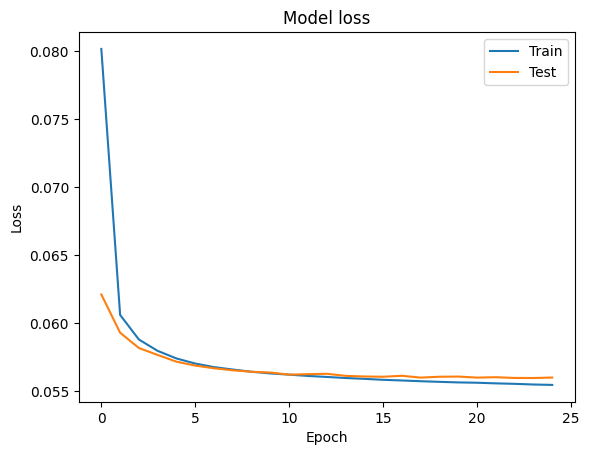

In [21]:
# Train the autoencoder
history = next_digit_autoencoder.fit(x_train, x_train_next_digit_random,
                epochs=25,
                batch_size=512,
                shuffle=True,
                validation_data=(x_test, x_test_next_digit_random), verbose = 0)

# Plot the training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

### Evaluation using MLP for digit classification

Predict on the test set

In [22]:
decoded_imgs = next_digit_autoencoder.predict(x_test)

313/313 [==============================] - 1s 2ms/step


Due to the tendency of the autoencoder to introduce considerable noise in the generated data, we plan to establish a threshold using Otsu's method to mitigate this effect.

In [23]:
from skimage import filters

decoded_imgs_binarized = (decoded_imgs > filters.threshold_otsu(decoded_imgs)+0.1).astype(np.float32)

We will construct a simple yet with high accuracy Multi-Layer Perceptron (MLP) and train it using the MNIST training set. This approach serves as a means to assess the performance of our autoencoder by evaluating the MLP's ability to predict the reconstructed images.

In [24]:
from tensorflow.keras import layers, models
from keras.layers import Dense, Dropout # core layers
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.preprocessing import OneHotEncoder

# Build the neural network model with L2 regularization and Dropout
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(28 * 28,)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# One-hot encode the target variables
encoder = OneHotEncoder(sparse_output=False)
y_train_one_hot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_one_hot = encoder.transform(y_test.reshape(-1, 1))

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with L2 regularization and Early Stopping
model.fit(x_train, y_train_one_hot, epochs=50, batch_size=64, validation_data=(x_test, y_test_one_hot), callbacks=[early_stopping], verbose = 1)

Epoch 1/50
938/938 [==============================] - 11s 11ms/step - loss: 0.3479 - accuracy: 0.8934 - val_loss: 0.1298 - val_accuracy: 0.9629
Epoch 2/50
938/938 [==============================] - 10s 11ms/step - loss: 0.1740 - accuracy: 0.9474 - val_loss: 0.0941 - val_accuracy: 0.9722
Epoch 3/50
938/938 [==============================] - 10s 11ms/step - loss: 0.1369 - accuracy: 0.9586 - val_loss: 0.0771 - val_accuracy: 0.9753
Epoch 4/50
938/938 [==============================] - 10s 11ms/step - loss: 0.1182 - accuracy: 0.9647 - val_loss: 0.0742 - val_accuracy: 0.9775
Epoch 5/50
938/938 [==============================] - 10s 11ms/step - loss: 0.1062 - accuracy: 0.9682 - val_loss: 0.0670 - val_accuracy: 0.9784
Epoch 6/50
938/938 [==============================] - 10s 10ms/step - loss: 0.0993 - accuracy: 0.9692 - val_loss: 0.0691 - val_accuracy: 0.9802
Epoch 7/50
938/938 [==============================] - 9s 10ms/step - loss: 0.0889 - accuracy: 0.9726 - val_loss: 0.0666 - val_accuracy: 

Let's see how accurate is the MLP model on the unseen test set's predictions

In [25]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test_one_hot)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

  1/313 [..............................] - ETA: 6s - loss: 0.0166 - accuracy: 1.0000

313/313 [==============================] - 0s 1ms/step - loss: 0.0604 - accuracy: 0.9835
Test Loss: 0.060392070561647415, Test Accuracy: 0.9835000038146973


We are able, then, to conclude that the MLP model is going to be a sufficient enough evaluation metric for this project and the next for the images classifications

We are going to use this trained MLP model to predict the reconstructed images from the autoencoder

In [26]:
pred_decoded_imgs = model.predict(decoded_imgs_binarized)
pred_decoded_imgs = np.argmax(pred_decoded_imgs, axis = 1)

313/313 [==============================] - 0s 1ms/step


In the final step, we will assess the performance of the autoencoder in predicting the input image and generating the subsequent image with the next digit in sequence.

In [27]:
from sklearn import metrics
metrics.accuracy_score(pred_decoded_imgs, (y_test + 1) % 10)

0.9339

We draw the conclusion that the autoencoder we created can with significant accuracy predict the input digit and reconstruct the next in sequence digit, marking the project a success

### Examples

In [28]:
(y_test[1:20] + 1) % 10, pred_decoded_imgs[1:20]

(array([6, 5, 0, 8, 2, 1, 0, 1, 5, 0, 1, 3, 8, 8, 7, 8, 9, 6, 7],
       dtype=uint8),
 array([6, 5, 0, 2, 2, 1, 0, 1, 5, 0, 1, 3, 8, 8, 7, 8, 9, 6, 1],
       dtype=int64))

Text(0.5, 1.0, 'Original Image')

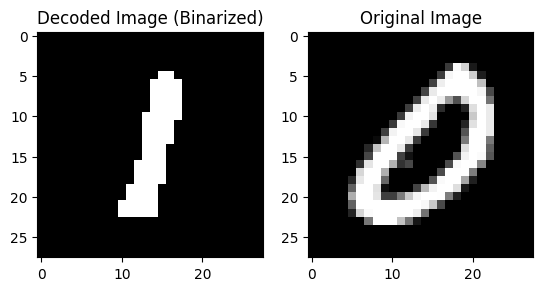

In [29]:
index = 33
# Plot the first image (decoded_imgs_binarized)
plt.subplot(1, 2, 1)
plt.imshow(decoded_imgs_binarized[index].reshape((28, 28)), cmap="gray")
plt.title('Decoded Image (Binarized) of the next digit')

# Plot the second image (x_test)
plt.subplot(1, 2, 2)
plt.imshow(x_test[index].reshape((28, 28)), cmap="gray")
plt.title('Original Image')